### Preprocessing Data

In [2]:
'''
Author: Reem Alatrash
Python ver: 2.7
Note(s): run in py 2.7 with the data extracted using py 2.7
'''
#>>>>>> Imports <<<<<<
from sklearn import preprocessing
import xarray as xr
import numpy
import pickle

#>>>>>> Variables <<<<<<
# Step 1: Preparing data
input_dir = "/mount/studenten/arbeitsdaten-studenten1/alatrarm/DL-project/" 
#names = ['data_prosody.train', 'data_logMel.train', 'data_prosody.valid', 'data_logMel.valid', 'data_prosody.test', 
#         'data_logMel.test']
file_paths = [input_dir + "data_prosody.train", input_dir + "data_logMel.train", input_dir + "data_prosody.valid", 
              input_dir + "data_logMel.valid", input_dir + "data_prosody.test", input_dir + "data_logMel.test"]

logMel_train_ids = []
logMel_train_features = []
logMel_train_labels = []
logMel_valid_ids = []
logMel_valid_features = []
logMel_valid_labels = []
logMel_test_ids = []
logMel_test_features = []
logMel_test_labels = []
input_height = 750 # height = no. of rows/segments (750)
input_width = 26 # this is the no. of cols (26 in logmel file)
# Fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

#>>>>>> functions <<<<<<
def unpickle_data(path):
    '''returns 3 lists: data Ids, features, labels'''    
    with open(path, 'rb') as f_in:
        ids = pickle.load(f_in)
        features = pickle.load(f_in)
        labels = pickle.load(f_in)
        #print(len(ids), len(features), len(labels))
        #print("{0}\n{1}\n{2}".format(ids[10],features[10],labels[10]))
        return ids, features, labels

# 1.1 unpickle files (load data)
logMel_file_paths = list(x for x in file_paths if "logMel" in x)
#print(logMel_file_paths)
logMel_train_ids,logMel_train_features,logMel_train_labels = unpickle_data(logMel_file_paths[0])
logMel_valid_ids,logMel_valid_features,logMel_valid_labels = unpickle_data(logMel_file_paths[1])
#logMel_test_ids,logMel_test_features,logMel_test_labels = unpickle_data(logMel_file_paths[2])

In [3]:
#1.2 Normalize data
train_scaler = preprocessing.Normalizer(norm='l2', copy=False).fit(logMel_train_features[0,:,:])
valid_scaler = preprocessing.Normalizer(norm='l2', copy=False).fit(logMel_valid_features[0,:,:])
#test_scaler = preprocessing.Normalizer(norm='l2', copy=False).fit(logMel_test_features[0,:,:])

train_scaler.transform(logMel_train_features[0,:,:])
valid_scaler.transform(logMel_valid_features[0,:,:])
#test_scaler.transform(logMel_test_features[0,:,:])

#print(logMel_train_features[0])

array([[-0.30185997, -0.17951228, -0.20728439, ..., -0.20882277,
        -0.20962653, -0.23362449],
       [-0.1370023 , -0.14933842, -0.15480784, ..., -0.19376287,
        -0.2273447 , -0.19915864],
       [-0.15421958, -0.14079733, -0.21985704, ..., -0.2208747 ,
        -0.21001929, -0.20459358],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [4]:
# 1.3.0 encode the string labels into numeric values    
le = preprocessing.LabelEncoder()
le.fit(["angry", "happy", "sad", "neutral"])
logMel_train_encoded_labels = le.transform(logMel_train_labels)
logMel_valid_encoded_labels = le.transform(logMel_valid_labels)

# to decode these labels use the following command: example
#results = list(le.inverse_transform([2, 2, 1]))

In [5]:
# 1.3.1 One hot encoding for the target vector
from keras.utils import np_utils
y_logMel_train_cat = np_utils.to_categorical(logMel_train_encoded_labels)
y_logMel_valid_cat = np_utils.to_categorical(logMel_valid_encoded_labels)

### Creating LSTM Model

In [15]:
# Step 2: define model
from keras.models import Sequential, Model
from keras.layers import Bidirectional, SimpleRNN, LSTM, Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.merge import Concatenate
from keras import optimizers

loss_func = 'categorical_crossentropy'
optimizer_func = 'RMSprop'
in_dense_units = 100 
in_dense_activ = 'tanh'
lstm_activ = 'tanh'
lstm_1_units = 32
lstm_2_units = 32
drop_rate1 = 0.0
drop_rate2 = 0.0#0.5
r_drop_rate1 = 0.25
r_drop_rate2 = 0.25

# 2.0 define model
# 2.1 use sequential model
model = Sequential()
# 2.2 add initial dense layer to handle input
#model.add(Dense(units=in_dense_units, activation=in_dense_activ, input_shape=(logMel_train_features.shape[1:])))
# 2.3 first LSTM layer 
model.add(LSTM(lstm_1_units, 
               dropout=drop_rate1, recurrent_dropout=r_drop_rate1, 
               input_shape=(logMel_train_features.shape[1:]))) #return_sequences=True, 
# 2.4 second LSTM layer 
#model.add(LSTM(lstm_2_units, dropout=drop_rate2, recurrent_dropout=r_drop_rate2))
# 2.5 Batch normalization
BatchNormalization(momentum=0.99)
# 2.6 softmax output layer
model.add(Dense(units=4, activation='softmax'))

# 2.7 customize the learning rate for our optimizer
rmsprop = optimizers.RMSprop(lr=0.003, rho=0.9, epsilon=None, decay=0.00)
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True)
optimizer_func = adam #rmsprop

# 2.8 compile the model and sow a summary
model.compile(loss=loss_func, optimizer=optimizer_func, metrics=['accuracy'])  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 750, 100)          2700      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Step 3: train model
# Paramters
total_epochs = 8 #50
batch_s = 128
number_training_samples = logMel_train_features.shape[1]
#history = model.fit(logMel_train_features, y_logMel_train_cat, 
#                    validation_data=(logMel_valid_features, y_logMel_valid_cat), 
#                    epochs=total_epochs, batch_size=batch_s, verbose=1, shuffle=True)
history = model.fit(logMel_train_features, y_logMel_train_cat, 
                    validation_data=(logMel_train_features, y_logMel_train_cat), 
                    epochs=total_epochs, batch_size=batch_s, verbose=1, shuffle=True)
#score = model.evaluate(logMel_valid_features, y_logMel_valid_cat, verbose=0)
score = model.evaluate(logMel_train_features, y_logMel_train_cat, verbose=0)
print("Accuracy on dev set:{0}%".format(score[1]*100))

Train on 5531 samples, validate on 5531 samples
Epoch 1/8
5531/5531 [==============================] - 47s 9ms/step - loss: 1.3634 - acc: 0.3045 - val_loss: 1.3565 - val_acc: 0.3177
Epoch 2/8
5531/5531 [==============================] - 48s 9ms/step - loss: 1.3578 - acc: 0.3195 - val_loss: 1.3554 - val_acc: 0.3173
Epoch 3/8
5531/5531 [==============================] - 55s 10ms/step - loss: 1.3575 - acc: 0.3032 - val_loss: 1.3532 - val_acc: 0.3195
Epoch 4/8
5531/5531 [==============================] - 54s 10ms/step - loss: 1.3554 - acc: 0.3180 - val_loss: 1.3522 - val_acc: 0.3202
Epoch 5/8
5531/5531 [==============================] - 55s 10ms/step - loss: 1.3544 - acc: 0.3074 - val_loss: 1.3521 - val_acc: 0.3202
Epoch 6/8
5531/5531 [==============================] - 55s 10ms/step - loss: 1.3557 - acc: 0.3108 - val_loss: 1.3514 - val_acc: 0.3211
Epoch 7/8
5531/5531 [==============================] - 55s 10ms/step - loss: 1.3513 - acc: 0.3175 - val_loss: 1.3502 - val_acc: 0.3216
Epoch 8/8

### Training History Visualization

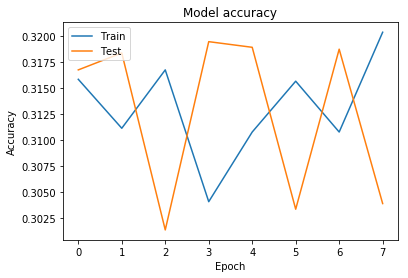

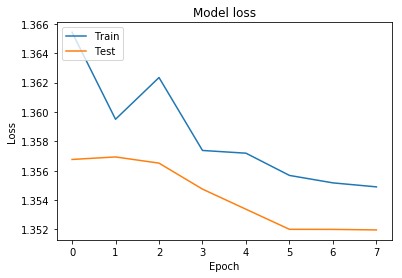

In [82]:
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Prediction

In [ ]:
# Step 4 Use model to predict
# 4.1 Get Probability distribution over the classes shape:(elements, classes)
prediction = model.predict(X_logMel_test_4D)

print("Prediction shape:{0}".format(prediction.shape))

print prediction[0]

# 4.2 Get the predictions list
predicted_classes = model.predict(X_logMel_test_4D).argmax(axis=1)
print("Prediction shape:{0}".format(predicted_classes.shape))
if len(logMel_test_ids) == len(predicted_classes):
    print("ids and classes lengths match")
print("{0}\t{1}".format(logMel_test_ids[0],predicted_classes[0]))

In [ ]:
# 4.3 Map predictions to ids and save to file
results = list(le.inverse_transform(predicted_classes))
#4.4 save results to file
with open("predictions_LSTM.txt", 'wb+') as f_out:
    for idx in range(0,len(logMel_test_ids)):
        f_out.write("{0}\t{1}\n".format(logMel_test_ids[idx],results[idx]))
print("done") 